In [ ]:
using Pkg
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("QuadGK")
Pkg.add("SpecialFunctions")
Pkg.add("Optim")
Pkg.add("Printf")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))

In [1]:
using SparseArrays
using NMarkov
using Plots
using Distributions
using QuadGK
using SpecialFunctions
using Optim
using Printf
using DataFrames
using CSV
using SparseMatrix

In [2]:
import NMarkov.eye
function eye(M::AbstractMatrix)
    eye(size(M)[1])
end

eye (generic function with 3 methods)

# Dekker and Dijkstra

In [3]:
function PProb(t0, D0, D1, dist)
    Q = D0 + D1
    I = eye(D0)
    p1 = mexpmix(Q, I; bounds = (0.0, t0), rmax = 10000) do t
        pdf(dist, t)
    end
    p2 = mexp(Q, I, t0, rmax = 10000)
    p3 = mexpmix(D0, I; bounds = (0.0, Inf64), rmax = 10000) do t
        pdf(dist, t+t0)
    end
    _, p4 = mexpcmix(D0, I; bounds = (0.0, Inf64), rmax = 10000) do t
        pdf(dist, t+t0)
    end
    gth(p1 + p2 * (p3 + p4*D1))
end

PProb (generic function with 1 method)

In [4]:
function g(t, t0, pss, D0, D1)
    Q = D0 + D1
    tmp = exp(Q*t0)' * pss
    y = exp(D0*t)' * tmp
    sum(D1' * y)
end

g (generic function with 1 method)

In [5]:
function T(t0, dist)
    res = quadgk(x -> ccdf(dist, x), 0, t0, rtol=1e-8)
    res[1]
end

T (generic function with 1 method)

In [6]:
function C(t0, dist, cp, cf)
    cp + (cf - cp)*cdf(dist, t0)
end

C (generic function with 1 method)

In [7]:
# standard age replacement
As(t0, dist, cp, cf) = C(t0, dist, cp, cf) / T(t0, dist)

As (generic function with 1 method)

In [8]:
# opportunity
function Aop(t0, dist, cp, cf, D0, D1)
    pss = PProb(t0, D0, D1, dist)
    res1 = quadgk(x -> T(t0 + x, dist) * g(x, t0, pss, D0, D1), 0, Inf, rtol=1e-8)
    res2 = quadgk(x -> C(t0 + x, dist, cp, cf) * g(x, t0, pss, D0, D1), 0, Inf, rtol=1e-8)
    res2[1] / res1[1]
end

Aop (generic function with 1 method)

In [9]:
# opportunity
function Aop2(t0, dist, cp, cf, init, D0, D1)
    res1 = quadgk(x -> T(t0 + x, dist) * g(x, t0, init, D0, D1), 0, Inf, rtol=1e-8)
    res2 = quadgk(x -> C(t0 + x, dist, cp, cf) * g(x, t0, init, D0, D1), 0, Inf, rtol=1e-8)
    res2[1] / res1[1]
end

Aop2 (generic function with 1 method)

In [10]:
function failure_param(;mttf, cv)
    m = optimize(m -> (gamma(1+2/m)/gamma(1+1/m)^2 - 1.0 - cv^2)^2, 0.0001, 10.0).minimizer
    eta = mttf / gamma(1+1/m)
    dist = Weibull(m, eta)

    println("failure shape parameter ", m)
    println("failure scale parameter ", eta)
    println("failure mttf ", mttf)
    println("failure cv ", cv)
    return dist
end

failure_param (generic function with 1 method)

In [11]:
function poisson_param(;mttop)
    # poisson
    D0 = Float64[-2 1; 1 -2]
    D1 = Float64[1 0; 0 1]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)

    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", sqrt(mo2 - mo^2)/mo)
    return D0, D1, 1.0
end

function hyporenewal_param(;mttop, b)
    # hypo renewal
#     b = Float64[1, 1]
    D0 = Float64[-b[1] b[1]; 0 -b[2]]
    D1 = Float64[0 0; b[2] 0]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)
    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv
end

function hyperrenewal_param(;mttop, u, b)
    # hyper exp
    D0 = Float64[-b[1] 0; 0 -b[2]]
    D1 = reshape(b, 2, 1) * reshape(u, 1, 2)

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)
    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv

end

function mmpp_param(;mttop, u, b)
    # mmpp
    D0 = Float64[-(u[1]+b[1]) u[1]; u[2] -(u[2]+b[2])]
    D1 = Float64[b[1] 0; 0 b[2]]

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)

    # scale
    D0 = D0 .* mo ./ mttop
    D1 = D1 .* mo ./ mttop

    ss = gth(Matrix(D0+D1))
    tmp = (-D0)' \ ss
    mo = sum(tmp)
    tmp = (-D0)' \ tmp
    mo2 = 2*sum(tmp)

    cv = sqrt(mo2 - mo^2)/mo
    println("mean opportunity interval ", mo)
    println("cv for opportunity interval ", cv)
    return D0, D1, cv
end

mmpp_param (generic function with 1 method)

In [12]:
cp, cf = 1.0, 10.0
dist = failure_param(mttf = 10.0, cv = 0.1)
D0, D1 = poisson_param(mttop = 1.0)

ts = LinRange(1, 20.0, 100)
value = [As(t0, dist, cp, cf) for t0 = ts]
value1 = [Aop(t0, dist, cp, cf, D0, D1) for t0 = ts];

failure shape parameter 9.999999703209413
failure scale parameter 10.511370074337558
failure mttf 10.0
failure cv 0.1
mean opportunity interval 1.0
cv for opportunity interval 1.0


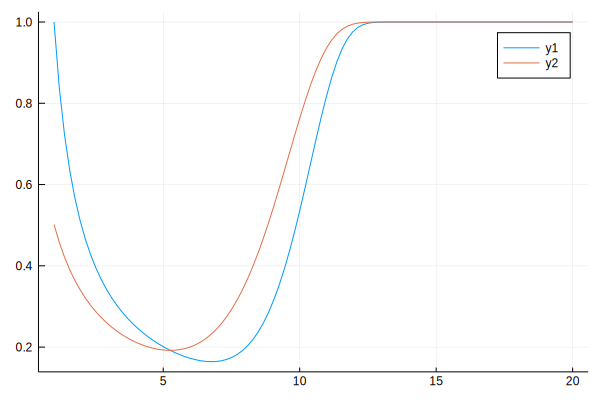

In [13]:
plot(ts, value)
plot!(ts, value1)

In [ ]:
cp = 1.0
cf = 10.0
mttf = 10.0
result = []
for cv in [0.1, 0.5, 0.8]
    println("cv ", cv)
    mttop = 0
    ocv = 0
    dist = failure_param(mttf = mttf, cv = cv)
    result0 = optimize(t0 -> As(t0, dist, cp, cf), 1, mttf*2)
    push!(result, ("st", cp, cv, mttop, ocv, result0.minimizer, result0.minimum, result0.converged))
    for co in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        println("co ", co)
        for mttop in [0.1, 1.0, 2.0, 5.0, 10.0]
            println("mttop ", mttop)
            D0, D1, ocv = poisson_param(mttop = mttop)
            result1 = optimize(t0 -> Aop(t0, dist, co, cf, D0, D1), 1, mttf*2)
            push!(result, ("poi", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            for b in [[1, 5], [1, 2], [1, 1]]
                D0, D1, ocv = hyporenewal_param(mttop = mttop, b=b)
                result1 = optimize(t0 -> Aop(t0, dist, co, cf, D0, D1), 1, mttf*2)
                push!(result, ("hypo", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            end
            b = [10, 1]
            for u in [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
                D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=u, b=b)
                result1 = optimize(t0 -> Aop(t0, dist, co, cf, D0, D1), 1, mttf*2)
                push!(result, ("hyper", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            end
            u = [1, 1]
            for b in [[1, 2], [1, 5], [1, 10]]
                D0, D1, ocv = mmpp_param(mttop = mttop, u=u, b=b)
                result1 = optimize(t0 -> Aop(t0, dist, co, cf, D0, D1), 1, mttf*2)
                push!(result, ("mmpp", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            end
        end
    end
end
result = DataFrame(result)
@show result
result |> CSV.write("lh.csv", delim=',', header=false)

In [20]:
cp = 1.0
cf = 10.0
mttf = 10.0
result = []
for cv in [0.1] # [0.1, 0.5, 0.8]
    println("cv ", cv)
    mttop = 0
    ocv = 0
    dist = failure_param(mttf = mttf, cv = cv)
#    result0 = optimize(t0 -> As(t0, dist, cp, cf), 1, mttf*2)
#    push!(result, ("st", cp, cv, mttop, ocv, result0.minimizer, result0.minimum, result0.converged))
    for co in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        println("co ", co)
        for mttop in [1.0] #[0.1, 1.0, 2.0, 5.0, 10.0]
            println("mttop ", mttop)
#            D0, D1, ocv = poisson_param(mttop = mttop)
#            result1 = optimize(t0 -> Aop(t0, dist, co, cf, D0, D1), 1, mttf*2)
#            push!(result, ("poi", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            for b in [[1,1], [1, 2]] # [[1, 5], [1, 2], [1, 1]]
                D0, D1, ocv = hyporenewal_param(mttop = mttop, b=b)
                init = Float64[1, 0]
                result1 = optimize(t0 -> Aop2(t0, dist, co, cf, init, D0, D1), 1, mttf*2)
                push!(result, ("hypo", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            end
            b = [10, 1]
            for u in [[0.5, 0.5], [0.8, 0.2]] # [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
                D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=u, b=b)
                init = u
                result1 = optimize(t0 -> Aop2(t0, dist, co, cf, init, D0, D1), 1, mttf*2)
                push!(result, ("hyper", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
            end
#             u = [1, 1]
#             for b in [[1, 2], [1, 5], [1, 10]]
#                 D0, D1, ocv = mmpp_param(mttop = mttop, u=u, b=b)
#                 init = Float64[0.5, 0.5]
#                 result1 = optimize(t0 -> Aop2(t0, dist, co, cf, init, D0, D1), 1, mttf*2)
#                 push!(result, ("mmpp", co, cv, mttop, ocv, result1.minimizer, result1.minimum, result1.converged))
#             end
        end
    end
end
result = DataFrame(result)
@show result
result |> CSV.write("lh2.csv", delim=',', header=false)

cv 0.1
failure shape parameter 9.999999703209413
failure scale parameter 10.511370074337558
failure mttf 10.0
failure cv 0.1
co 0.5
mttop 1.0
mean opportunity interval 1.0
cv for opportunity interval 0.8819171036881968
mean opportunity interval 1.0
cv for opportunity interval 0.9147320339189785
mean opportunity interval 1.0
cv for opportunity interval 1.0764794285093986
mean opportunity interval 1.0
cv for opportunity interval 1.2645601709825842
co 0.6
mttop 1.0
mean opportunity interval 1.0
cv for opportunity interval 0.8819171036881968
mean opportunity interval 1.0
cv for opportunity interval 0.9147320339189785
mean opportunity interval 1.0
cv for opportunity interval 1.0764794285093986
mean opportunity interval 1.0
cv for opportunity interval 1.2645601709825842
co 0.7
mttop 1.0
mean opportunity interval 1.0
cv for opportunity interval 0.8819171036881968
mean opportunity interval 1.0
cv for opportunity interval 0.9147320339189785
mean opportunity interval 1.0
cv for opportunity inter

"lh2.csv"

In [19]:
cp = 1.0
cf = 10.0
co = 0.5
mttf = 10.0
cv = 0.1
mttop = 1.0
dist = failure_param(mttf = mttf, cv = cv)
# D0, D1, ocv = poisson_param(mttop = mttop)
# D0, D1, ocv = hyporenewal_param(mttop = mttop, b=[1,2]) # [[1, 5], [1, 2], [1, 1]]
# D0, D1, ocv = mmpp_param(mttop = mttop, u=[1,1], b=[1,10]) # u=[1,1] b=[[1, 2], [1, 5], [1, 10]]
D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=[0.8,0.2], b=[10,1]) # b = [10, 1], u = [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
result1 = optimize(t0 -> Aop(t0, dist, co, cf, D0, D1), 0.0001, mttf*2)
println(result1)

failure shape parameter 9.999999703209413
failure scale parameter 10.511370074337558
failure mttf 10.0
failure cv 0.1
mean opportunity interval 1.0
cv for opportunity interval 1.2645601709825842
Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000100, 20.000000]
 * Minimizer: 4.338772e+00
 * Minimum: 1.251985e-01
 * Iterations: 10
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 11


In [20]:
for mttop in [1.0, 5.0]
    println("mttop ", mttop)
    D0, D1, ocv = poisson_param(mttop = mttop)
    println("poi", D0, D1)
    for b in [[1, 5], [1, 2], [1, 1]]
        D0, D1, ocv = hyporenewal_param(mttop = mttop, b=b)
        println("hypo", D0, D1)
    end
    b = [10, 1]
    for u in [[0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
        D0, D1, ocv = hyperrenewal_param(mttop = mttop, u=u, b=b)
        println("hyper", D0, D1)
    end
    u = [1, 1]
    for b in [[1, 2], [1, 5], [1, 10]]
        D0, D1, ocv = mmpp_param(mttop = mttop, u=u, b=b)
        println("mmpp", D0, D1)
    end
end

mttop 1.0
mean opportunity interval 1.0
cv for opportunity interval 1.0
poi[-2.0 1.0; 1.0 -2.0][1.0 0.0; 0.0 1.0]
mean opportunity interval 1.0
cv for opportunity interval 0.9736379530830044
hypo[-1.03333 1.03333; 0.0 -5.16667][0.0 0.0; 5.16667 0.0]
mean opportunity interval 1.0
cv for opportunity interval 0.9147320339189785
hypo[-1.16667 1.16667; 0.0 -2.33333][0.0 0.0; 2.33333 0.0]
mean opportunity interval 1.0
cv for opportunity interval 0.8819171036881968
hypo[-1.5 1.5; 0.0 -1.5][0.0 0.0; 1.5 0.0]
mean opportunity interval 1.0
cv for opportunity interval 1.0199501246882794
hyper[-9.78049 0.0; 0.0 -0.978049][1.9561 7.82439; 0.19561 0.782439]
mean opportunity interval 1.0
cv for opportunity interval 1.0764794285093986
hyper[-9.18182 0.0; 0.0 -0.918182][4.59091 4.59091; 0.459091 0.459091]
mean opportunity interval 1.0
cv for opportunity interval 1.2645601709825842
hyper[-7.42857 0.0; 0.0 -0.742857][5.94286 1.48571; 0.594286 0.148571]
mean opportunity interval 1.0000000000000002
cv for 

In [22]:
5.94286/(5.94286+1.48571)

0.800000538461642